<a href="https://colab.research.google.com/github/sSteam-cube/P_345-P_343-Laboratory-Resources/blob/main/Diffraction/P345_Diffraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def least_squares_analysis(y_values, x_values=None, title="Least Squares Analysis"):
    """
    Perform least squares regression, show plot with regression results,
    and display the calculation table below.

    Parameters
    ----------
    y_values : list or array
        Dependent variable values (y).
    x_values : list or array, optional
        Independent variable values (x). If None, uses 1,2,...,N.
    title : str, optional
        Title of the combined figure.
    """

    # Convert to numpy arrays
    y = np.array(y_values, dtype=float)
    if x_values is None:
        x = np.arange(1, len(y)+1, dtype=float)
    else:
        x = np.array(x_values, dtype=float)

    # Perform least-squares fit: y = m*x + c
    A = np.vstack([x, np.ones(len(x))]).T
    slope, intercept = np.linalg.lstsq(A, y, rcond=None)[0]

    # Fitted values and residuals
    y_fit = slope * x + intercept
    residuals = y - y_fit

    # Error in slope (standard error)
    N = len(x)
    Sxx = np.sum((x - np.mean(x))**2)
    sigma_y = np.sqrt(np.sum(residuals**2) / (N-2))
    err_slope = sigma_y / np.sqrt(Sxx)

    # Create DataFrame table
    df = pd.DataFrame({
        "x": x,
        "y": y,
        "x²": x**2,
        "xy": x*y
    })
    totals = pd.DataFrame({
        "x": [np.sum(x)],
        "y": [np.sum(y)],
        "x²": [np.sum(x**2)],
        "xy": [np.sum(x*y)]
    }, index=["Σ"])
    table = pd.concat([df, totals])

    # --- Combined Figure: Plot + Table ---
    fig, (ax1, ax2) = plt.subplots(
        nrows=2, ncols=1, figsize=(10,9),
        gridspec_kw={"height_ratios": [3, 1]}  # plot taller than table
    )

    # Top: Regression plot
    ax1.scatter(x, y, color='blue', label="Data points")
    ax1.plot(x, y_fit, color='red', label="Best Fit Line")

    textstr = '\n'.join((
        f"Slope (m)     = {slope:.4f}",
        f"Intercept (c) = {intercept:.4f}",
        f"Slope Error   = {err_slope:.4f}"
    ))
    ax1.text(0.05, 0.95, textstr, transform=ax1.transAxes,
             fontsize=10, verticalalignment='top',
             bbox=dict(boxstyle="round,pad=0.3", facecolor="wheat", alpha=0.5))

    ax1.set_xlabel("m")
    ax1.set_ylabel("xₘ")
    ax1.legend()
    # ax1.set_title(f"Least Squares Fit of xₘ vs m")
    ax1.grid(True)

    # Bottom: Table
    ax2.axis("off")
    table_fig = ax2.table(cellText=table.round(3).values,
                          colLabels=table.columns,
                          rowLabels=table.index,
                          cellLoc='center', loc='center')

    table_fig.auto_set_font_size(False)
    table_fig.set_fontsize(10)
    table_fig.scale(1.3, 1.3)

    plt.suptitle(title, fontsize=14, y=0.98)
    plt.tight_layout()
    plt.show()

    # Return results in case needed programmatically
    return {
        "slope": slope,
        "intercept": intercept,
        "slope_error": err_slope,
        "table": table
    }


# PART 1

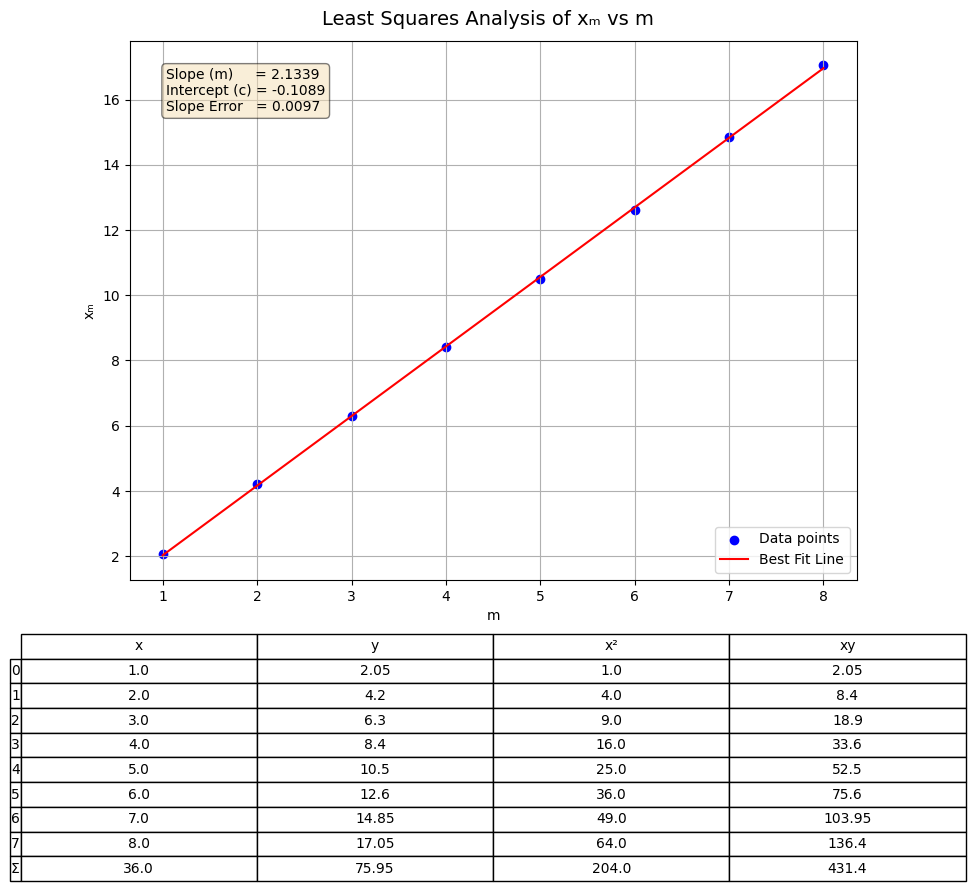

In [ ]:
y1 = [2.05, 4.2, 6.3, 8.4, 10.5, 12.6, 14.85, 17.05]  # xm values

result = least_squares_analysis(y1, title="Least Squares Analysis of xₘ vs m")

In [ ]:
b = 18e-5
D = 2.9

l = (result['slope']*b*1e7)/(2*D)
l

np.float64(662.2536945812809)

# PART 2

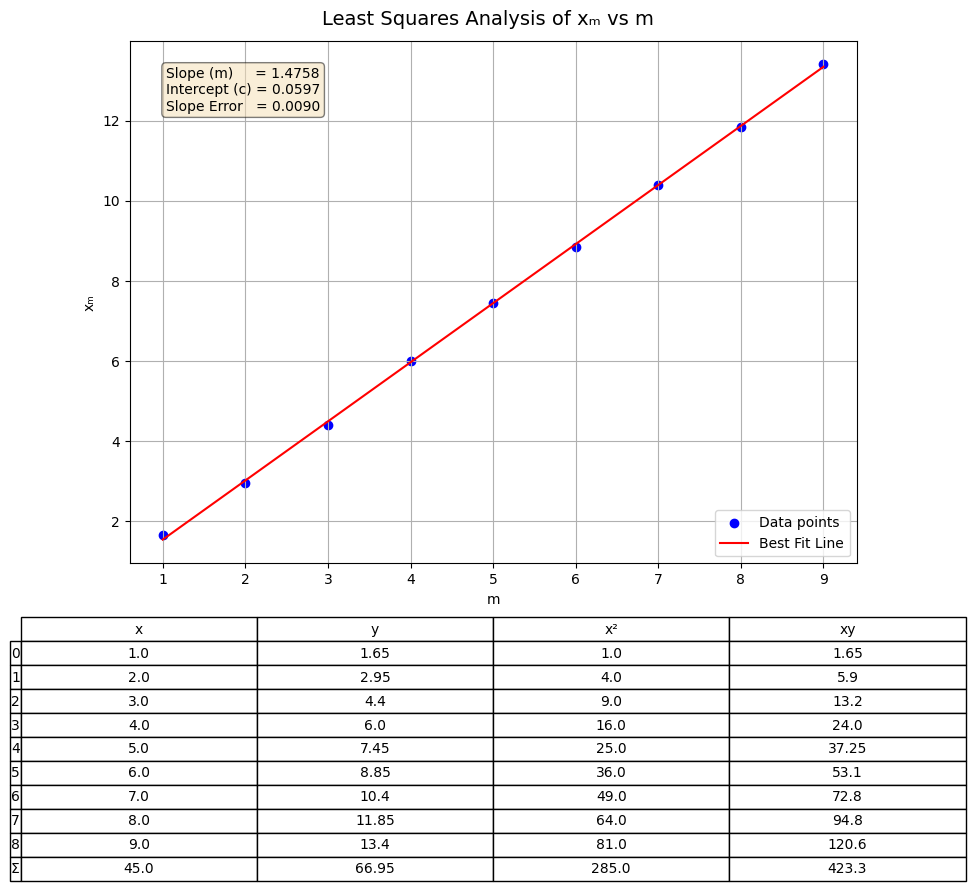

In [ ]:
y1 = [1.65, 2.95, 4.4, 6.0, 7.45, 8.85, 10.4, 11.85, 13.40]

result = least_squares_analysis(y1, title="Least Squares Analysis of xₘ vs m")

In [ ]:
l = 632.8e-7
D = 231

b = (2*D*l)/result['slope']
b

np.float64(0.019809391304347824)

# Double Slit Diffraction

In [ ]:
import numpy as np

def d_b_from_four_lists(xp_left, xp_right, xm_left, xm_right, lam_cm, D_cm):
    """
    Compute slit separation d and slit width b from left/right readings.

    Parameters
    ----------
    xp_left, xp_right : list[float]
        Interference minima positions on left/right (cm), measured from the central maximum
        along each side (signs allowed; magnitudes are used).
    xm_left, xm_right : list[float]
        Diffraction minima positions on left/right (cm), same convention.
    lam_cm : float
        Wavelength in cm (e.g., 632.8 nm -> 6.328e-5 cm).
    D_cm : float
        Slit-to-screen distance in cm.

    Returns
    -------
    results : dict
        Keys (each np.ndarray unless noted):
        - 'Δxp_left', 'Δxp_right', 'Δxm_left', 'Δxm_right' : deltas vs the first reading per side
        - 'orders_p_left', 'orders_p_right', 'orders_m_left', 'orders_m_right' : i = 1..N-1
        - 'd_left', 'd_right' : d values from each side
        - 'b_left', 'b_right' : b values from each side
        - 'd_avg', 'b_avg' : overall averages over both sides (NaNs ignored)
    """
    def prepare_side(arr):
        arr = np.abs(np.asarray(arr, dtype=float))
        if arr.size < 2:
            raise ValueError("Each side must have at least two readings.")
        deltas = arr[1:] - arr[0]              # Δx_i = x_i - x_0  (i=1..N-1)
        orders = np.arange(1, arr.size)        # i = 1..N-1
        return deltas, orders

    # Build deltas and order indices for each side
    Δxp_L, ipL = prepare_side(xp_left)
    Δxp_R, ipR = prepare_side(xp_right)
    Δxm_L, imL = prepare_side(xm_left)
    Δxm_R, imR = prepare_side(xm_right)

    # Safe division (ignore zero/negative Δ by setting NaN)
    def safe_ratio(orders, deltas):
        out = np.full_like(deltas, np.nan, dtype=float)
        mask = deltas > 0
        out[mask] = (orders[mask] * lam_cm * D_cm) / deltas[mask]
        return out

    # Two sets of d's and b's (left/right)
    d_left  = safe_ratio(ipL, Δxp_L)
    d_right = safe_ratio(ipR, Δxp_R)
    b_left  = safe_ratio(imL, Δxm_L)
    b_right = safe_ratio(imR, Δxm_R)

    # Averages across both sides (ignore NaNs)
    d_avg = np.nanmean(np.concatenate([d_left, d_right]))
    b_avg = np.nanmean(np.concatenate([b_left, b_right]))

    return {
        "Δxp_left": Δxp_L, "Δxp_right": Δxp_R,
        "Δxm_left": Δxm_L, "Δxm_right": Δxm_R,
        "orders_p_left": ipL, "orders_p_right": ipR,
        "orders_m_left": imL, "orders_m_right": imR,
        "d_left": d_left, "d_right": d_right,
        "b_left": b_left, "b_right": b_right,
        "d_avg": d_avg, "b_avg": b_avg,
    }

# ---- Example (replace with your data) ----
if __name__ == "__main__":
    lam_cm = 632.8e-7   # 632.8 nm He-Ne -> cm
    D_cm   = 251.0      # screen distance in cm

    xp_left  = [.1, .6, 1.3, 2.1, 3.6, 5, 6.6, 8, 9.5, 11]
    xp_right = [.4, .9, 1.4, 2.4, 3.7, 5.3, 6.8, 8.3, 9.8, 11.3]
    xm_left  = [1.5, 2.7, 4.4, 5.75, 7.25, 8.75, 10.3]
    xm_right = [1.6, 3, 4.6, 6.05, 7.55, 9.05, 10.50]

    res = d_b_from_four_lists(xp_left, xp_right, xm_left, xm_right, lam_cm, D_cm)
    print("Δxp_left (cm): ", res["Δxp_left"])
    print("Δxp_right(cm): ", res["Δxp_right"])
    print("d_left  (cm):  ", res["d_left"])
    print("d_right (cm):  ", res["d_right"])
    print("Δxm_left (cm): ", res["Δxm_left"])
    print("Δxm_right(cm): ", res["Δxm_right"])
    print("b_left  (cm):  ", res["b_left"])
    print("b_right (cm):  ", res["b_right"])
    print("Average d (cm):", res["d_avg"])
    print("Average b (cm):", res["b_avg"])


Δxp_left (cm):  [ 0.5  1.2  2.   3.5  4.9  6.5  7.9  9.4 10.9]
Δxp_right(cm):  [ 0.5  1.   2.   3.3  4.9  6.4  7.9  9.4 10.9]
d_left  (cm):   [0.03176656 0.02647213 0.02382492 0.01815232 0.01620743 0.01466149
 0.01407379 0.01351769 0.01311463]
d_right (cm):   [0.03176656 0.03176656 0.02382492 0.01925246 0.01620743 0.01489058
 0.01407379 0.01351769 0.01311463]
Δxm_left (cm):  [1.2  2.9  4.25 5.75 7.25 8.8 ]
Δxm_right(cm):  [1.4  3.   4.45 5.95 7.45 8.9 ]
b_left  (cm):   [0.01323607 0.01095399 0.01121173 0.01104924 0.01095399 0.01082951]
b_right (cm):   [0.0113452  0.01058885 0.01070783 0.01067784 0.01065992 0.01070783]
Average d (cm): 0.019455865558926862
Average b (cm): 0.01107683166738054


<>:15: SyntaxWarning: invalid escape sequence '\D'
<>:15: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipython-input-1869769650.py:15: SyntaxWarning: invalid escape sequence '\D'
  least_squares_analysis(x1, title="Least Squares Analysis of avg($\Delta x_m$) vs n")


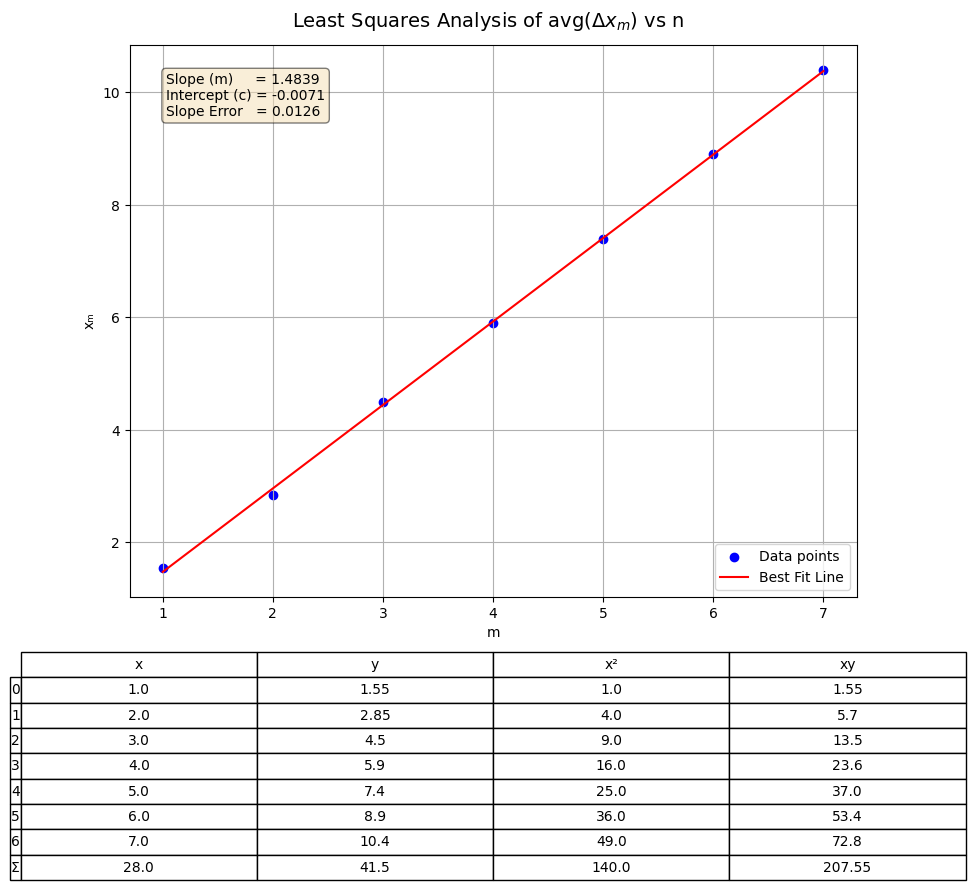

{'slope': np.float64(1.4839285714285717),
 'intercept': np.float64(-0.007142857142855697),
 'slope_error': np.float64(0.012550916707718254),
 'table':       x      y     x²      xy
 0   1.0   1.55    1.0    1.55
 1   2.0   2.85    4.0    5.70
 2   3.0   4.50    9.0   13.50
 3   4.0   5.90   16.0   23.60
 4   5.0   7.40   25.0   37.00
 5   6.0   8.90   36.0   53.40
 6   7.0  10.40   49.0   72.80
 Σ  28.0  41.50  140.0  207.55}

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Example data
xp_left  = np.array([.1, .6, 1.3, 2.1, 3.6, 5, 6.6, 8, 9.5, 11])
xp_right = np.array([.4, .9, 1.4, 2.4, 3.7, 5.3, 6.8, 8.3, 9.8, 11.3])
xm_left  = np.array([1.5, 2.7, 4.4, 5.75, 7.25, 8.75, 10.3])
xm_right = np.array([1.6, 3, 4.6, 6.05, 7.55, 9.05, 10.50])


x1 = (xm_left+xm_right)/2
x2 = (xp_left+xp_right)/2

least_squares_analysis(x1, title="Least Squares Analysis of avg($\Delta x_m$) vs n")


<>:1: SyntaxWarning: invalid escape sequence '\D'
<>:1: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipython-input-1960738755.py:1: SyntaxWarning: invalid escape sequence '\D'
  least_squares_analysis(x2, title="Least Squares Analysis of avg($\Delta x_p$) vs n")


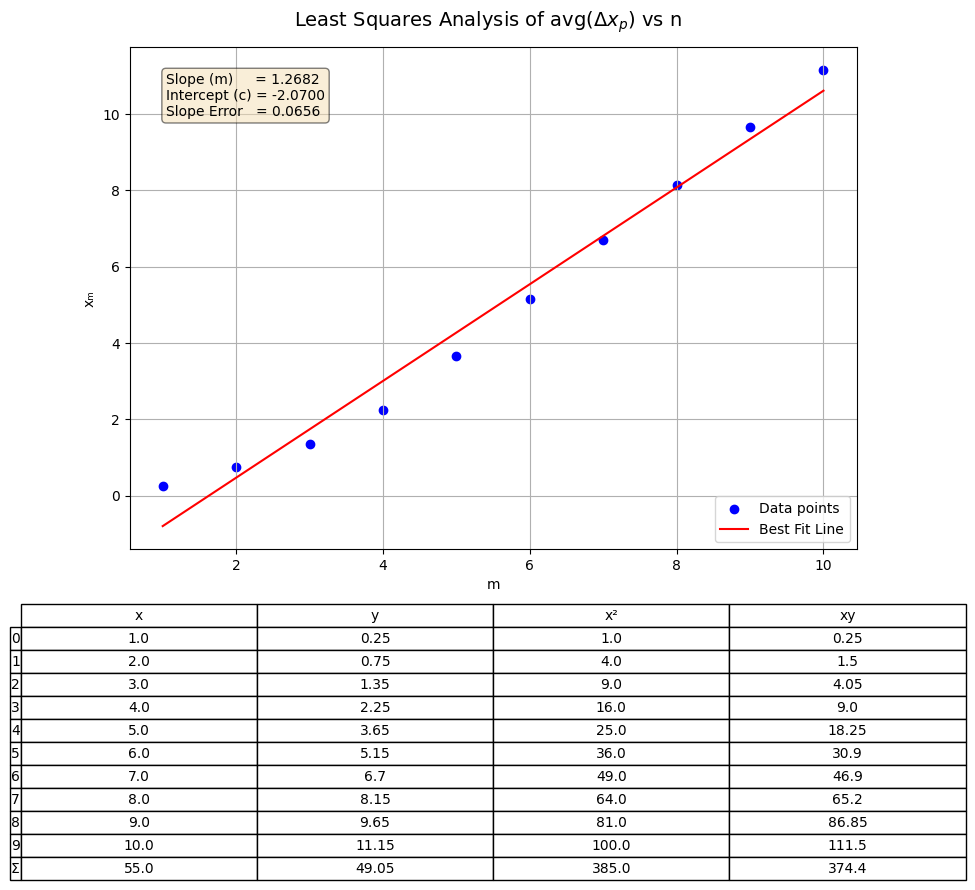

{'slope': np.float64(1.2681818181818183),
 'intercept': np.float64(-2.07),
 'slope_error': np.float64(0.06558278682988894),
 'table':       x      y     x²      xy
 0   1.0   0.25    1.0    0.25
 1   2.0   0.75    4.0    1.50
 2   3.0   1.35    9.0    4.05
 3   4.0   2.25   16.0    9.00
 4   5.0   3.65   25.0   18.25
 5   6.0   5.15   36.0   30.90
 6   7.0   6.70   49.0   46.90
 7   8.0   8.15   64.0   65.20
 8   9.0   9.65   81.0   86.85
 9  10.0  11.15  100.0  111.50
 Σ  55.0  49.05  385.0  374.40}

In [ ]:
least_squares_analysis(x2, title="Least Squares Analysis of avg($\Delta x_p$) vs n")